In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit_ibm_runtime import QiskitRuntimeService


In [3]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t

In [4]:
#creazione del NoiseModel e del pm
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeMontrealV2

QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)

#FakeManila è datato, utilizziamo FakeMontrealV2
fake_backend = FakeMontrealV2()


In [5]:
#La curva esatta

et_steps = 100 #la curva esatta deve essere accurata
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
et_ts = np.linspace(0, dt, et_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in et_ts]

In [6]:
#definiamo il numero di time steps, creiamo ts e definiamo "prj"
t_steps = 12 #così ogni step è di 0.25
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3
ts = np.linspace(0, dt, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


In [7]:
#facciamo andare il circuito con 12 trotter step senza error mitigation
probs_unopt = []
probs_unopt_error = []

no_pm = generate_preset_pass_manager(optimization_level=0, backend=fake_backend)

for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=t_steps,t=sim_t)
    qc = qc.compose(trott_steps)
    
    isa_circuit = no_pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_unopt.append(trotter_value.mean().real)
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_unopt_error.append(delta)
    

    
print("12 steps NO Optimization completed")

12 steps NO Optimization completed


In [19]:
#facciamo andare il circuito con 12 trotter step con ottimizzazione

pm3 = generate_preset_pass_manager(optimization_level=2, backend=fake_backend)
probs_OPT3 = []
probs_OPT_error3 = []


for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=t_steps,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm3.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_OPT3.append(trotter_value.mean().real)
    #exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_OPT_error3.append(delta)
    
print("12 steps  OPT completed")

12 steps  OPT completed


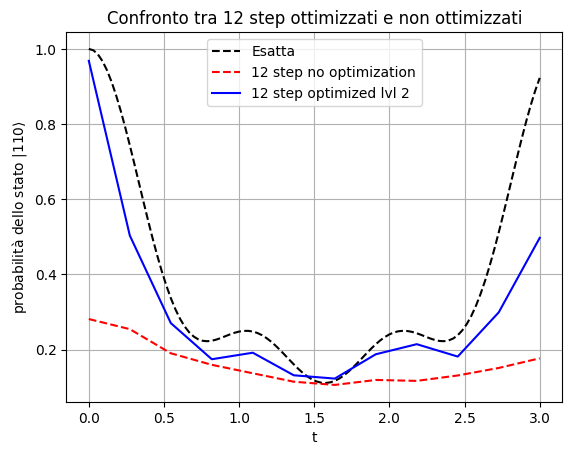

In [21]:
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_unopt,color="red",linestyle="dashed",label="12 step no optimization")
plt.plot(ts, probs_OPT3,color="blue",label="12 step optimized lvl 2")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 12 step ottimizzati e non ottimizzati')
plt.legend()
plt.grid()
plt.savefig('../../png/error_mitigation/Error_mitigation.png')
plt.show()

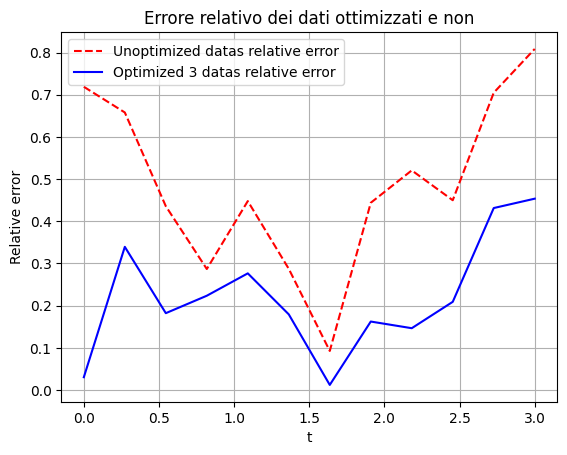

In [10]:
plt.plot(ts, probs_unopt_error,color="red",linestyle="dashed",label="Unoptimized datas relative error")
plt.plot(ts, probs_OPT_error3,color="blue",label="Optimized 3 datas relative error")
plt.xlabel('t')
plt.ylabel(r'Relative error')
plt.title(r'Errore relativo dei dati ottimizzati e non')
plt.legend()
plt.grid()
plt.savefig('../../png/error_mitigation/Relative_error.png')
plt.show()

In [11]:

pm1 = generate_preset_pass_manager(optimization_level=1, backend=fake_backend)
probs_OPT1 = []
probs_OPT_error1 = []


pm2 = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
probs_OPT2 = []
probs_OPT_error2 = []



In [12]:
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=t_steps,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm1.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_OPT1.append(trotter_value.mean().real)
    #exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_OPT_error1.append(delta)

In [13]:
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=t_steps,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm2.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_OPT2.append(trotter_value.mean().real)
    #exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_OPT_error2.append(delta)

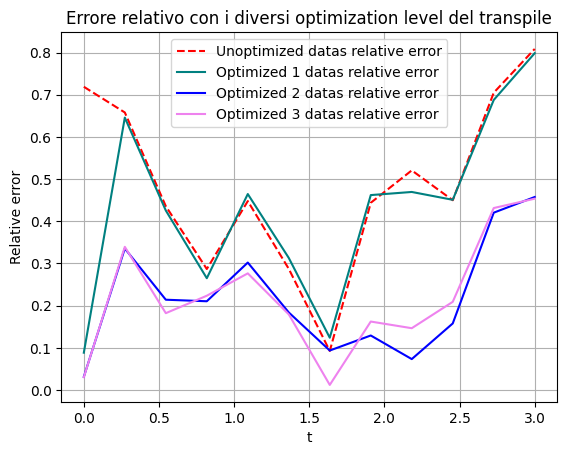

In [14]:
plt.plot(ts, probs_unopt_error,color="red",linestyle="dashed",label="Unoptimized datas relative error")
plt.plot(ts, probs_OPT_error1,color="teal",label="Optimized 1 datas relative error")
plt.plot(ts, probs_OPT_error2,color="blue",label="Optimized 2 datas relative error")
plt.plot(ts, probs_OPT_error3,color="violet",label="Optimized 3 datas relative error")
plt.xlabel('t')
plt.ylabel(r'Relative error')
plt.title(r'Errore relativo con i diversi optimization level del transpile')
plt.legend()
plt.grid()
plt.savefig('../../png/error_mitigation/transpile_levels.png')
plt.show()

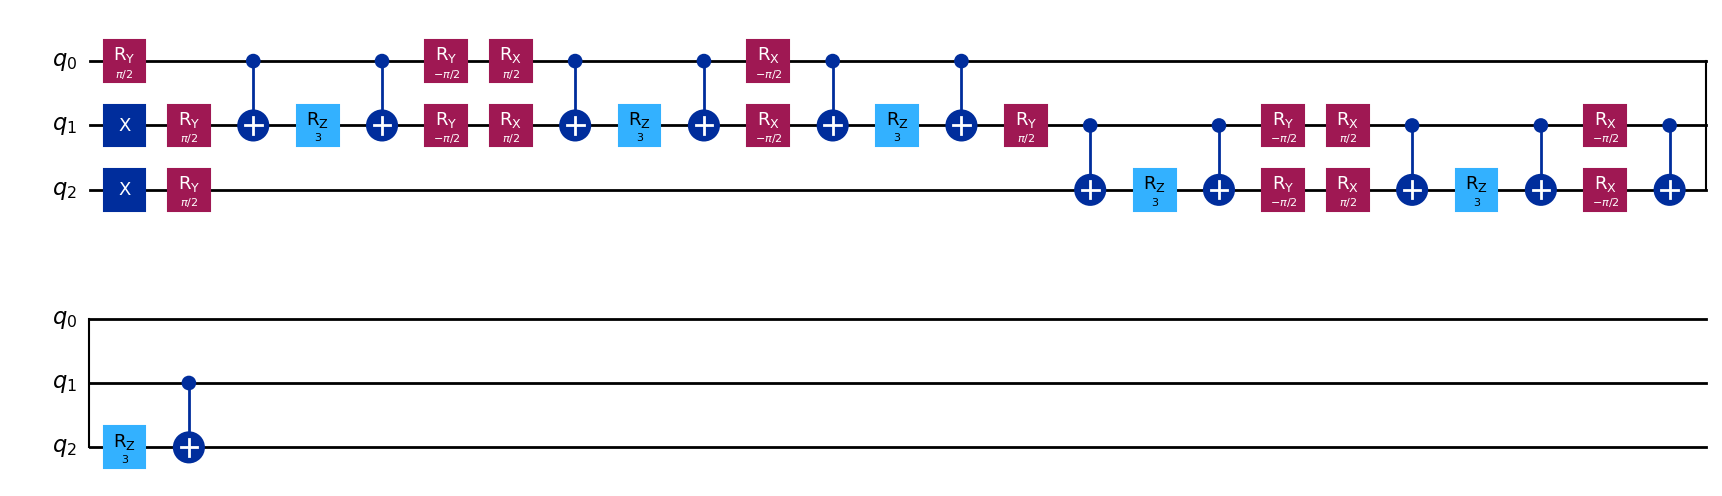

In [15]:
qc_raw = QuantumCircuit(3)
#buildiamo lo stato "110"
qc_raw.x(1)
qc_raw.x(2)
trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=1,t=1.5)
qc_raw = qc_raw.compose(trott_steps)
qc_raw.draw(output='mpl', filename='../../circuit_drawing/raw_circuit.png')

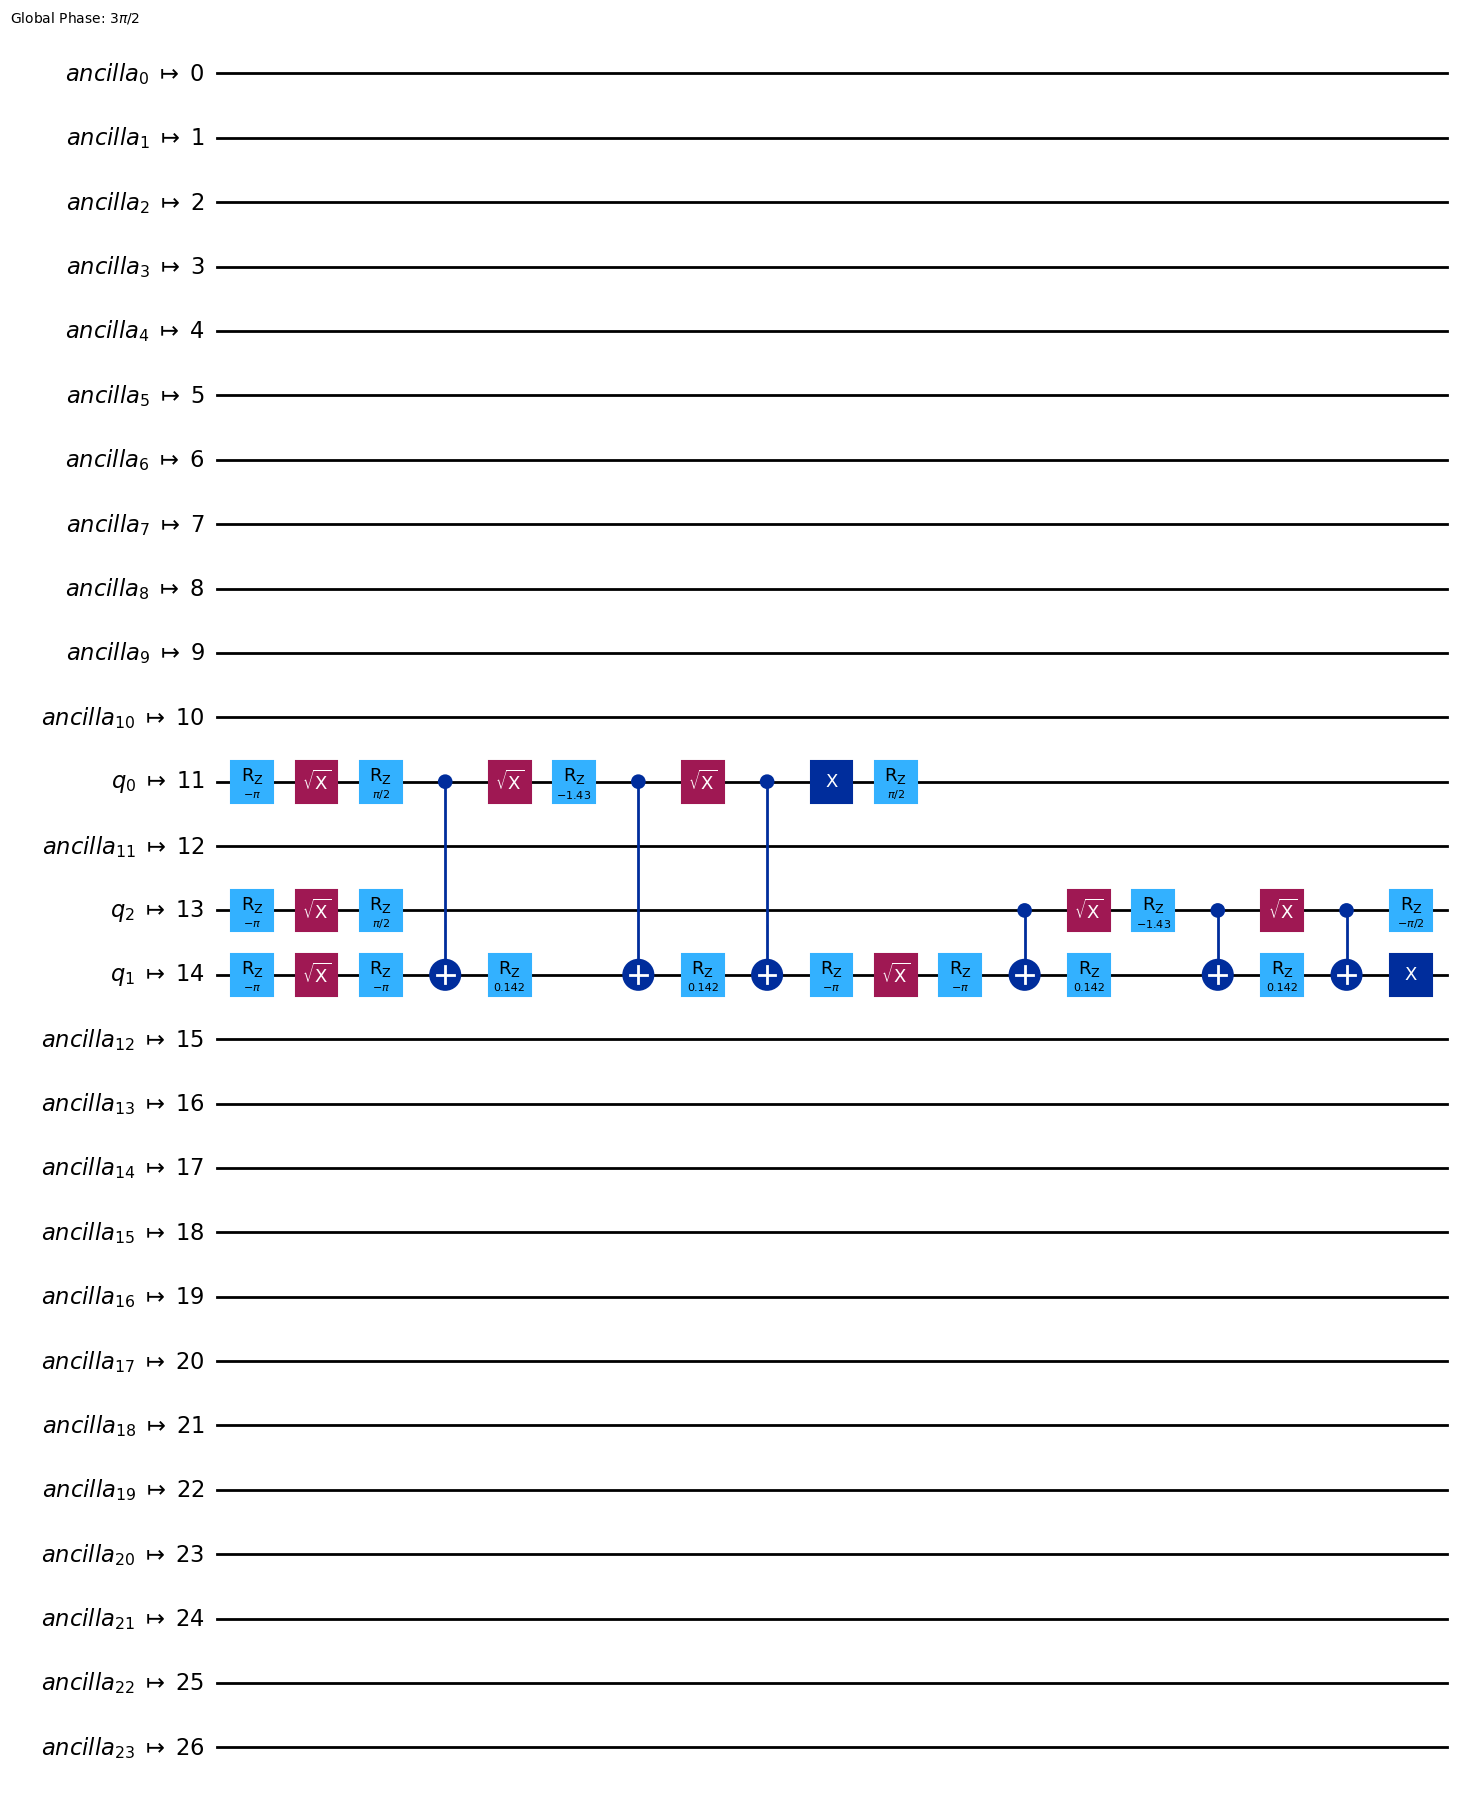

In [16]:
isa_circuit = pm2.run(qc_raw)
isa_circuit.draw(output='mpl', filename='../../circuit_drawing/transpiled_circuit.png')